### **Эксперимент 6.**

Построить отдельные модели для NAI = 1, NAI = 0. Результат смотрим суммарно. Использовать конфигурацию эксперимента 5 (или 4, если лучше)

Сохранить и записать использованные константы.

In [1]:
import pandas as pd
import numpy as np 

y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']
features = ['egt', 'tat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ff', 'nf']

In [2]:
fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])

In [3]:
bgu[features].describe()

,egt,tat,n1a,n2a,wai,nai,prv,alt,mn,ff,nf
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.0,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000
mean,881.023533,10.019341,84.353228,90.568820,0.0,0.099401,0.524551,2029.298802,0.269987,3353.665269,84.427425
std,65.296382,13.194295,3.845682,2.578436,0.0,0.299290,0.499546,807.240095,0.014911,342.072757,3.888364
min,696.000000,-24.000000,73.280000,82.900000,0.0,0.000000,0.000000,404.000000,0.220000,2568.000000,73.260000
25%,836.225000,-0.200000,81.890000,88.780000,0.0,0.000000,0.000000,1534.000000,0.261000,3139.500000,81.920000
50%,888.550000,11.850000,84.330000,90.970000,0.0,0.000000,1.000000,1861.500000,0.270000,3323.000000,84.395000
75%,926.500000,21.000000,87.027500,92.467500,0.0,0.000000,1.000000,2342.000000,0.279000,3547.750000,87.132500
max,1044.100000,37.000000,94.360000,96.730000,0.0,1.000000,1.000000,6769.000000,0.350000,4327.000000,94.560000


In [4]:
from utils import *

data = build_dataset(
  [bgu, bdu], 
  y_cols, 
  meta_cols, 
  features,
  n_back=13,
)

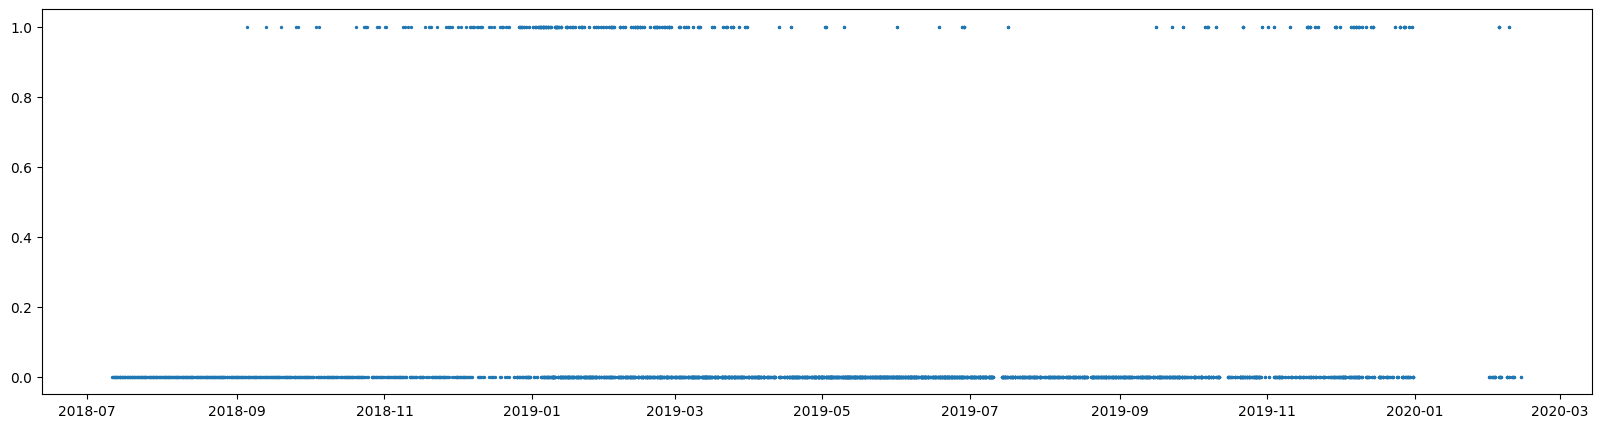

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.scatter(data['reportts'], data['nai'], s=2)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def predict_ensemble(models: List[LinearRegression], X: pd.DataFrame, y):
  pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
  for val in [True, False]:
    X_f, y_f = filter_split_by_field(X, y, 'nai', val)
    pred.loc[X['nai'] == val, 'pred'] = models[val].predict(X_f)
  return pred

def filter_split_by_field(X: pd.DataFrame, y: pd.DataFrame, field: str, value: bool):
  return X[X[field] == value], y[X[field] == value]

def train_ensemble_model(X, y, model = 'linreg'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  ensemble = dict()
  ensemble[True] = LinearRegression()
  ensemble[False] = LinearRegression()

  for val in [True, False]:
    X_train_f, y_train_f = filter_split_by_field(X_train, y_train, 'nai', val)
    ensemble[val].fit(X_train_f, y_train_f)
  
  predicted_train = predict_ensemble(ensemble, X_train, y_train)

  predicted_test = predict_ensemble(ensemble, X_test, y_test)
  mse = mean_squared_error(y_test, predicted_test, squared=False)
  mae = mean_absolute_error(y_test, predicted_test)
  r2 = r2_score(y_test, predicted_test)

  return mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test

In [7]:
X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test = train_ensemble_model(X, y)

print(f'Baseline: rmse = {mse:.3f} mae = {mae:.3f} r2 = {r2:.3f}')


Baseline: rmse = 2.063 mae = 1.587 r2 = 0.238


In [9]:
predicted_test

,pred
2828,22.9294
2829,20.5532
2830,15.5585
2831,20.6472
2832,15.5095
...,...
3766,14.0919
3767,15.5461
3768,13.6266
3769,16.4156


In [12]:
# plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test['pred'], predicted_train['pred'], is_smooth=True)